# FloPy 

### Working stack demo

A short demonstration of core `flopy` functionality

In [1]:
from IPython.display import clear_output, display

import time
import os
import sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

# run installed version of flopy or add local path
try:
    import flopy
except:
    fpth = os.path.abspath(os.path.join('..', '..'))
    sys.path.append(fpth)
    import flopy

print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('pandas version: {}'.format(pd.__version__))
print('flopy version: {}'.format(flopy.__version__))

3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]
numpy version: 1.18.1
matplotlib version: 3.1.2
pandas version: 0.25.3
flopy version: 3.3.4


### Model Inputs

In [2]:
# first lets load an existing model
model_ws = os.path.join("..", "data", "freyberg_multilayer_transient")
ml = flopy.modflow.Modflow.load("freyberg.nam", model_ws=model_ws, verbose=False,
                               check=False, exe_name="mfnwt")

c:\users\jlarsen\desktop\flopy-dev\flopy\mbase.py:356: DeprecationWarning: xul/yul have been deprecated. Use xll/yll instead.
  DeprecationWarning,


In [4]:
ml.modelgrid

xll:622241.1904510253; yll:3343617.741737109; rotation:15.0; proj4_str:+proj=utm +zone=14 +ellps=WGS84 +datum=WGS84 +units=m +no_defs; units:meters; lenuni:2

Let's looks at some plots

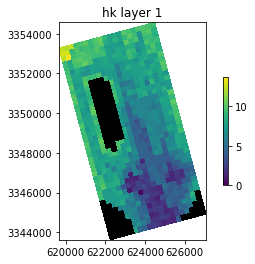

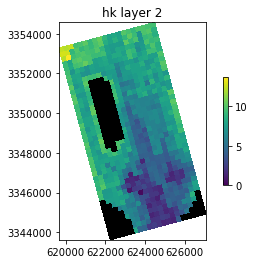

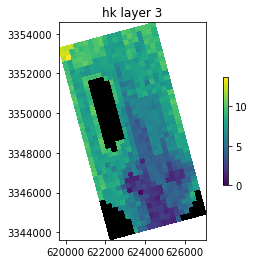

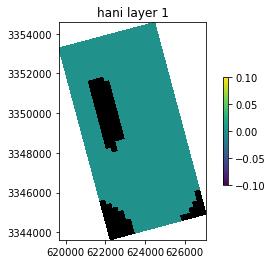

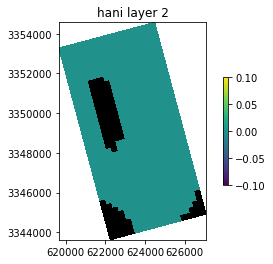

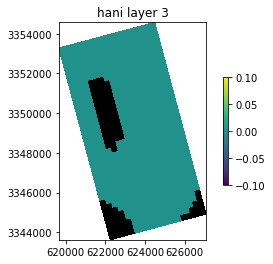

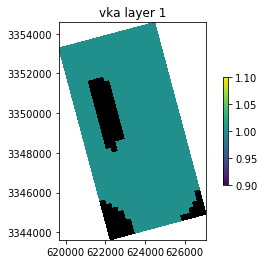

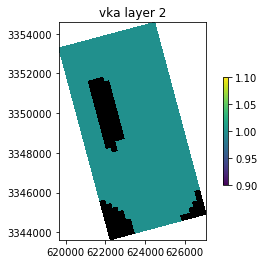

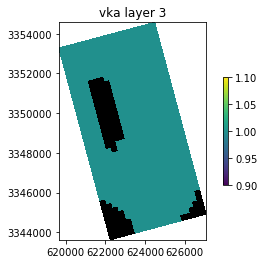

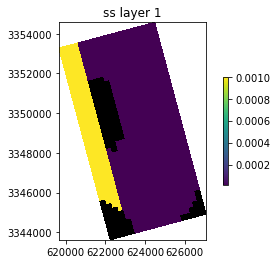

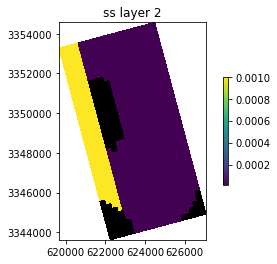

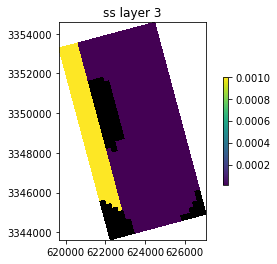

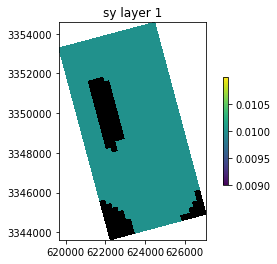

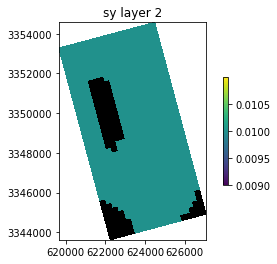

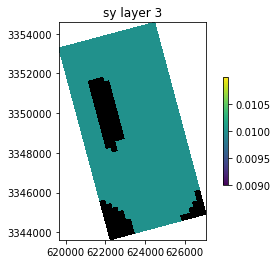

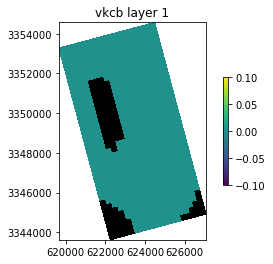

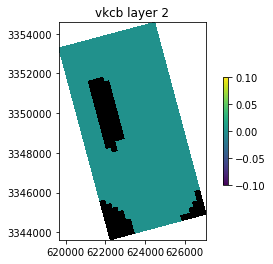

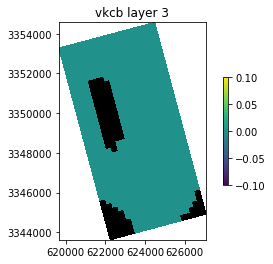

In [5]:
ml.upw.plot();

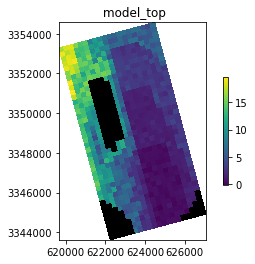

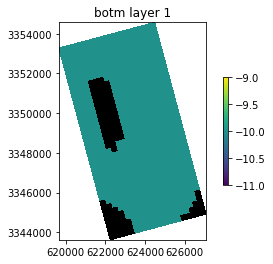

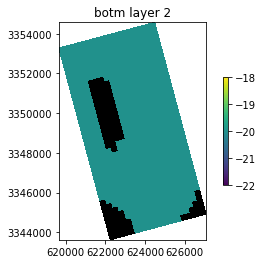

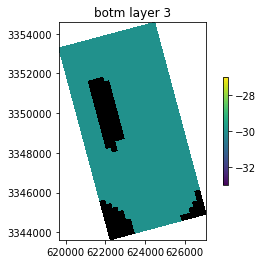

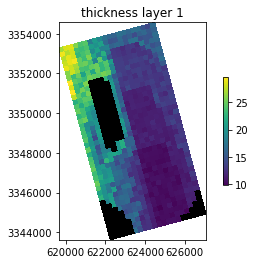

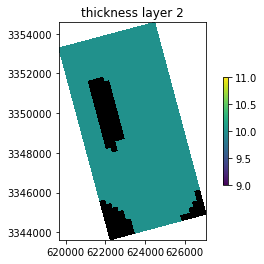

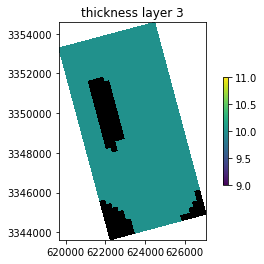

In [6]:
ml.dis.plot();

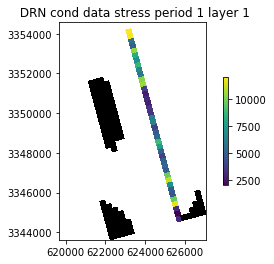

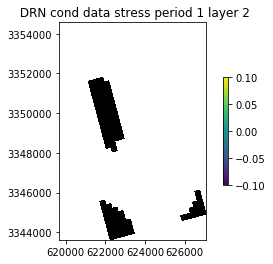

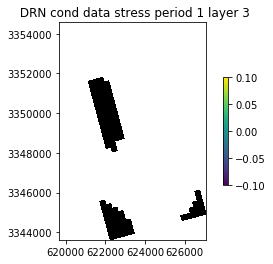

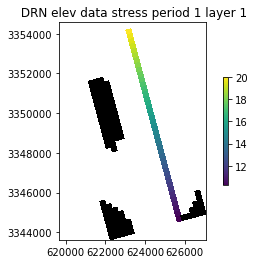

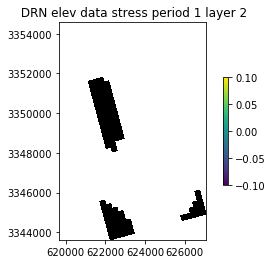

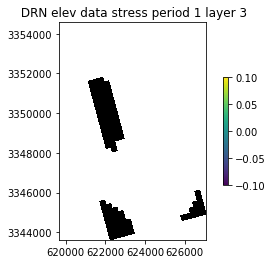

In [7]:
ml.drn.plot(key="cond")
ml.drn.plot(key="elev");

Let's write a shapefile of the DIS package

In [8]:
ml.dis.export(os.path.join('data',"freyberg_dis.shp"))

wrote data\freyberg_dis.shp


c:\users\jlarsen\desktop\flopy-dev\flopy\modflow\mfdis.py:642: PendingDeprecationWarning: ModflowDis.thickness will be deprecated and removed in version 3.3.5.  Use grid.thick().
  PendingDeprecationWarning,
c:\users\jlarsen\desktop\flopy-dev\flopy\modflow\mfdis.py:642: PendingDeprecationWarning: ModflowDis.thickness will be deprecated and removed in version 3.3.5.  Use grid.thick().
  PendingDeprecationWarning,


Let's also write a netCDF file with all model inputs

In [9]:
ml.export(os.path.join('data', "freyberg.nc"))

initialize_geometry::proj4_str = +proj=utm +zone=14 +ellps=WGS84 +datum=WGS84 +units=m +no_defs
initialize_geometry::self.grid_crs = +proj=utm +zone=14 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs
initialize_geometry::nc_crs = epsg:4326
transforming coordinates using = proj=pipeline step inv proj=utm zone=14 ellps=WGS84 step proj=unitconvert xy_in=rad xy_out=deg


c:\users\jlarsen\desktop\flopy-dev\flopy\utils\reference.py:2090: DeprecationWarning: crs has been deprecated and will be removed in version 3.3.5. Use CRS in shapefile_utils instead.
  category=DeprecationWarning,
c:\users\jlarsen\desktop\flopy-dev\flopy\modflow\mfdis.py:642: PendingDeprecationWarning: ModflowDis.thickness will be deprecated and removed in version 3.3.5.  Use grid.thick().
  PendingDeprecationWarning,
c:\users\jlarsen\desktop\flopy-dev\flopy\modflow\mfwel.py:281: DeprecationWarning: phiramp_unit will be replaced with iunitramp for consistency
  warnings.warn(err, DeprecationWarning)


### Change model directory, modify inputs and write new input files

In [10]:
ml.external_path = "ref"
ml.model_ws = "data"


changing model workspace...
   data


### Run the model

In [11]:
ml.write_input()

ml.run_model()

Util2d:delr: resetting 'how' to external
Util2d:delc: resetting 'how' to external
Util2d:model_top: resetting 'how' to external
Util2d:botm_layer_0: resetting 'how' to external
Util2d:botm_layer_1: resetting 'how' to external
Util2d:botm_layer_2: resetting 'how' to external
Util2d:ibound_layer_0: resetting 'how' to external
Util2d:ibound_layer_1: resetting 'how' to external
Util2d:ibound_layer_2: resetting 'how' to external
Util2d:strt_layer_0: resetting 'how' to external
Util2d:strt_layer_1: resetting 'how' to external
Util2d:strt_layer_2: resetting 'how' to external
Util2d:rech_1: resetting 'how' to external
Util2d:rech_2: resetting 'how' to external
Util2d:rech_3: resetting 'how' to external
Util2d:rech_4: resetting 'how' to external
Util2d:rech_5: resetting 'how' to external
Util2d:rech_6: resetting 'how' to external
Util2d:rech_7: resetting 'how' to external
Util2d:rech_8: resetting 'how' to external
Util2d:rech_9: resetting 'how' to external
Util2d:rech_10: resetting 'how' to ext

Util2d:rech_180: resetting 'how' to external
Util2d:rech_181: resetting 'how' to external
Util2d:rech_182: resetting 'how' to external
Util2d:rech_183: resetting 'how' to external
Util2d:rech_184: resetting 'how' to external
Util2d:rech_185: resetting 'how' to external
Util2d:rech_186: resetting 'how' to external
Util2d:rech_187: resetting 'how' to external
Util2d:rech_188: resetting 'how' to external
Util2d:rech_189: resetting 'how' to external
Util2d:rech_190: resetting 'how' to external
Util2d:rech_191: resetting 'how' to external
Util2d:rech_192: resetting 'how' to external
Util2d:rech_193: resetting 'how' to external
Util2d:rech_194: resetting 'how' to external
Util2d:rech_195: resetting 'how' to external
Util2d:rech_196: resetting 'how' to external
Util2d:rech_197: resetting 'how' to external
Util2d:rech_198: resetting 'how' to external
Util2d:rech_199: resetting 'how' to external
Util2d:rech_200: resetting 'how' to external
Util2d:rech_201: resetting 'how' to external
Util2d:rec

Util2d:rech_414: resetting 'how' to external
Util2d:rech_415: resetting 'how' to external
Util2d:rech_416: resetting 'how' to external
Util2d:rech_417: resetting 'how' to external
Util2d:rech_418: resetting 'how' to external
Util2d:rech_419: resetting 'how' to external
Util2d:rech_420: resetting 'how' to external
Util2d:rech_421: resetting 'how' to external
Util2d:rech_422: resetting 'how' to external
Util2d:rech_423: resetting 'how' to external
Util2d:rech_424: resetting 'how' to external
Util2d:rech_425: resetting 'how' to external
Util2d:rech_426: resetting 'how' to external
Util2d:rech_427: resetting 'how' to external
Util2d:rech_428: resetting 'how' to external
Util2d:rech_429: resetting 'how' to external
Util2d:rech_430: resetting 'how' to external
Util2d:rech_431: resetting 'how' to external
Util2d:rech_432: resetting 'how' to external
Util2d:rech_433: resetting 'how' to external
Util2d:rech_434: resetting 'how' to external
Util2d:rech_435: resetting 'how' to external
Util2d:rec

Util2d:rech_648: resetting 'how' to external
Util2d:rech_649: resetting 'how' to external
Util2d:rech_650: resetting 'how' to external
Util2d:rech_651: resetting 'how' to external
Util2d:rech_652: resetting 'how' to external
Util2d:rech_653: resetting 'how' to external
Util2d:rech_654: resetting 'how' to external
Util2d:rech_655: resetting 'how' to external
Util2d:rech_656: resetting 'how' to external
Util2d:rech_657: resetting 'how' to external
Util2d:rech_658: resetting 'how' to external
Util2d:rech_659: resetting 'how' to external
Util2d:rech_660: resetting 'how' to external
Util2d:rech_661: resetting 'how' to external
Util2d:rech_662: resetting 'how' to external
Util2d:rech_663: resetting 'how' to external
Util2d:rech_664: resetting 'how' to external
Util2d:rech_665: resetting 'how' to external
Util2d:rech_666: resetting 'how' to external
Util2d:rech_667: resetting 'how' to external
Util2d:rech_668: resetting 'how' to external
Util2d:rech_669: resetting 'how' to external
Util2d:rec

Util2d:rech_838: resetting 'how' to external
Util2d:rech_839: resetting 'how' to external
Util2d:rech_840: resetting 'how' to external
Util2d:rech_841: resetting 'how' to external
Util2d:rech_842: resetting 'how' to external
Util2d:rech_843: resetting 'how' to external
Util2d:rech_844: resetting 'how' to external
Util2d:rech_845: resetting 'how' to external
Util2d:rech_846: resetting 'how' to external
Util2d:rech_847: resetting 'how' to external
Util2d:rech_848: resetting 'how' to external
Util2d:rech_849: resetting 'how' to external
Util2d:rech_850: resetting 'how' to external
Util2d:rech_851: resetting 'how' to external
Util2d:rech_852: resetting 'how' to external
Util2d:rech_853: resetting 'how' to external
Util2d:rech_854: resetting 'how' to external
Util2d:rech_855: resetting 'how' to external
Util2d:rech_856: resetting 'how' to external
Util2d:rech_857: resetting 'how' to external
Util2d:rech_858: resetting 'how' to external
Util2d:rech_859: resetting 'how' to external
Util2d:rec

Util2d:hk: resetting 'how' to external
Util2d:vk: resetting 'how' to external
Util2d:ss: resetting 'how' to external
Util2d:sy: resetting 'how' to external
Util2d:hk: resetting 'how' to external
Util2d:vk: resetting 'how' to external
Util2d:ss: resetting 'how' to external
Util2d:sy: resetting 'how' to external
Util2d:hk: resetting 'how' to external
Util2d:vk: resetting 'how' to external
Util2d:ss: resetting 'how' to external
Util2d:sy: resetting 'how' to external
FloPy is using the following  executable to run the model: .\mfnwt.EXE

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.2.0 03/01/2020                        
                    BASED ON MODFLOW-2005 Version 1.12.0 02/03/2017                       

                    SWR1 Version 1.04.0 09/15/2016                       

 Using NAME file: freyberg.nam 
 R

 Solving:  Stress period:    97    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:    98    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:    99    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   100    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   101    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   102    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   103    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   104    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   105    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   106    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   107    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   108    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   109    Time step:     1    Groundwater-Flow Eqn.

 Solving:  Stress period:   209    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   210    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   211    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   212    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   213    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   214    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   215    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   216    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   217    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   218    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   219    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   220    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   221    Time step:     1    Groundwater-Flow Eqn.

 Solving:  Stress period:   317    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   318    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   319    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   320    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   321    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   322    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   323    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   324    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   325    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   326    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   327    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   328    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   329    Time step:     1    Groundwater-Flow Eqn.

 Solving:  Stress period:   428    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   429    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   430    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   431    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   432    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   433    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   434    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   435    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   436    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   437    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   438    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   439    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   440    Time step:     1    Groundwater-Flow Eqn.

 Solving:  Stress period:   537    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   538    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   539    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   540    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   541    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   542    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   543    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   544    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   545    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   546    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   547    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   548    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   549    Time step:     1    Groundwater-Flow Eqn.

 Solving:  Stress period:   645    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   646    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   647    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   648    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   649    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   650    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   651    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   652    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   653    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   654    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   655    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   656    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   657    Time step:     1    Groundwater-Flow Eqn.

 Solving:  Stress period:   762    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   763    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   764    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   765    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   766    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   767    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   768    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   769    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   770    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   771    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   772    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   773    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   774    Time step:     1    Groundwater-Flow Eqn.

 Solving:  Stress period:   877    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   878    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   879    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   880    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   881    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   882    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   883    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   884    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   885    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   886    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   887    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   888    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   889    Time step:     1    Groundwater-Flow Eqn.

 Solving:  Stress period:   985    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   986    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   987    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   988    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   989    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   990    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   991    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   992    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   993    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   994    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   995    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   996    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   997    Time step:     1    Groundwater-Flow Eqn.

 Solving:  Stress period:  1096    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:  1097    Time step:     1    Groundwater-Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2021/07/12 11:03:53
 Elapsed run time: 19.751 Seconds

  Normal termination of simulation


(True, [])

### Output inspection

First, let's look at the list file

In [12]:
mfl = flopy.utils.MfListBudget(os.path.join(model_ws,"freyberg.list"))
df_flux, df_vol = mfl.get_dataframes(start_datetime="10-21-2015")
df_flux

,STORAGE_IN,CONSTANT_HEAD_IN,WELLS_IN,DRAINS_IN,RECHARGE_IN,TOTAL_IN,STORAGE_OUT,CONSTANT_HEAD_OUT,WELLS_OUT,DRAINS_OUT,RECHARGE_OUT,TOTAL_OUT,IN-OUT,PERCENT_DISCREPANCY
2015-10-22,0.000000,0.000000,0.0,0.0,6276.861816,6276.861816,0.000000,2446.318848,0.000000,3830.650146,0.0,6276.968750,-0.106900,-0.0
2015-10-23,635.447998,0.000000,0.0,0.0,6428.198730,7063.646484,31.594000,2430.337891,1302.403198,3299.415039,0.0,7063.750000,-0.103500,-0.0
2015-10-24,1361.814941,0.000000,0.0,0.0,5397.295898,6759.110840,9.152200,2369.628174,1618.676392,2761.639648,0.0,6759.096191,0.014648,0.0
2015-10-25,677.577209,0.000000,0.0,0.0,5931.377441,6608.954590,180.233307,2353.585449,1498.694702,2576.461670,0.0,6608.975586,-0.020996,-0.0
2015-10-26,697.818298,0.000000,0.0,0.0,8378.572266,9076.390625,1051.897461,2417.248291,3119.501953,2487.737305,0.0,9076.384766,0.005859,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-10-18,1298.433350,23.293699,0.0,0.0,4240.286133,5562.013184,1606.280396,1909.538574,1930.483154,115.724899,0.0,5562.026855,-0.013672,-0.0
2018-10-19,920.468689,25.997499,0.0,0.0,4082.749512,5029.215820,1659.194702,1892.605835,1279.166382,198.258896,0.0,5029.225586,-0.009766,-0.0
2018-10-20,496.671387,20.047001,0.0,0.0,5053.779297,5570.497559,2428.291016,1933.045898,794.582886,414.594513,0.0,5570.514648,-0.017090,-0.0
2018-10-21,230.320999,9.045700,0.0,0.0,6168.920410,6408.287109,2335.759521,2006.124268,1373.782593,692.638123,0.0,6408.304688,-0.017578,-0.0


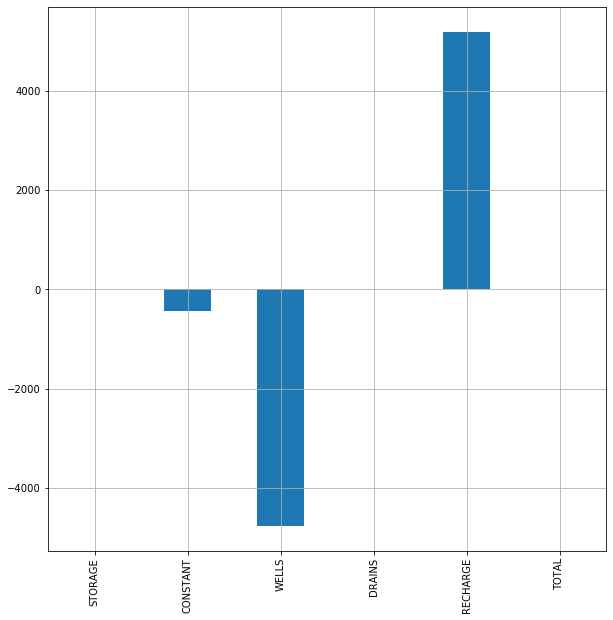

In [13]:
groups = df_flux.groupby(lambda x:x.split('_')[-1],axis=1).groups
df_flux_in = df_flux.loc[:,groups["IN"]]
df_flux_in.columns = df_flux_in.columns.map(lambda x:x.split('_')[0])

df_flux_out = df_flux.loc[:,groups["OUT"]]
df_flux_out.columns = df_flux_out.columns.map(lambda x:x.split('_')[0])


df_flux_delta = df_flux_in - df_flux_out
df_flux_delta.iloc[-1,:].plot(kind="bar",figsize=(10,10),grid=True);

### Let's look at the simulated head

In [14]:
# if you pass the model instance, then the plots will be offset and rotated
h = flopy.utils.HeadFile(os.path.join(model_ws,"freyberg.hds"),model=ml)
h.times

[1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 24.0,
 25.0,
 26.0,
 27.0,
 28.0,
 29.0,
 30.0,
 31.0,
 32.0,
 33.0,
 34.0,
 35.0,
 36.0,
 37.0,
 38.0,
 39.0,
 40.0,
 41.0,
 42.0,
 43.0,
 44.0,
 45.0,
 46.0,
 47.0,
 48.0,
 49.0,
 50.0,
 51.0,
 52.0,
 53.0,
 54.0,
 55.0,
 56.0,
 57.0,
 58.0,
 59.0,
 60.0,
 61.0,
 62.0,
 63.0,
 64.0,
 65.0,
 66.0,
 67.0,
 68.0,
 69.0,
 70.0,
 71.0,
 72.0,
 73.0,
 74.0,
 75.0,
 76.0,
 77.0,
 78.0,
 79.0,
 80.0,
 81.0,
 82.0,
 83.0,
 84.0,
 85.0,
 86.0,
 87.0,
 88.0,
 89.0,
 90.0,
 91.0,
 92.0,
 93.0,
 94.0,
 95.0,
 96.0,
 97.0,
 98.0,
 99.0,
 100.0,
 101.0,
 102.0,
 103.0,
 104.0,
 105.0,
 106.0,
 107.0,
 108.0,
 109.0,
 110.0,
 111.0,
 112.0,
 113.0,
 114.0,
 115.0,
 116.0,
 117.0,
 118.0,
 119.0,
 120.0,
 121.0,
 122.0,
 123.0,
 124.0,
 125.0,
 126.0,
 127.0,
 128.0,
 129.0,
 130.0,
 131.0,
 132.0,
 133.0,
 134.0,
 135.0,
 136.0,
 137.0,
 138.0,
 139

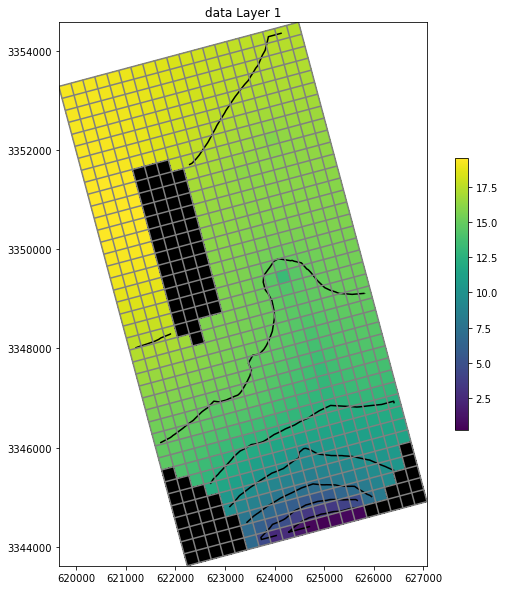

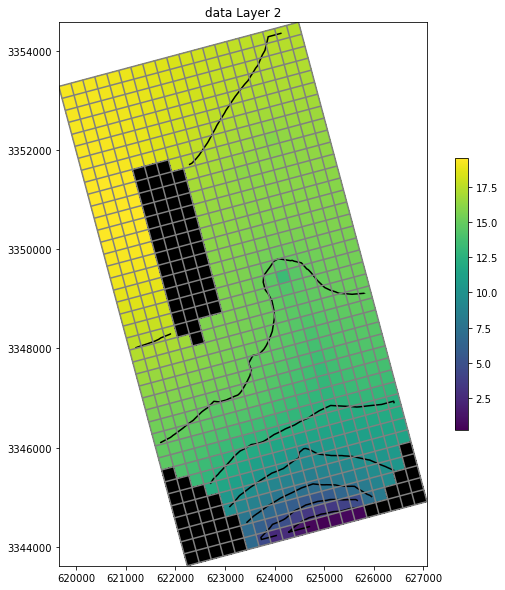

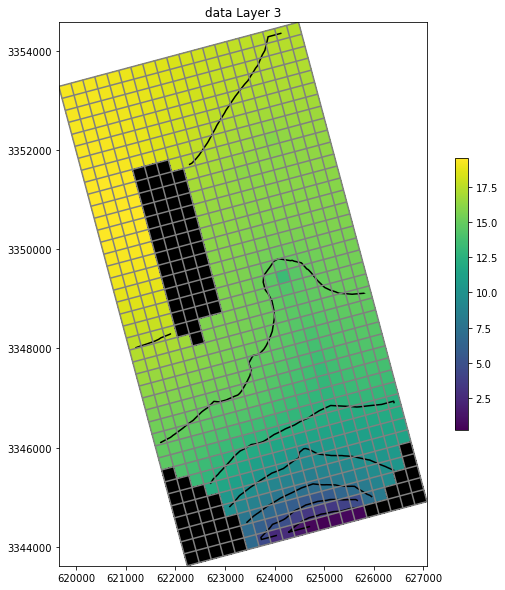

In [15]:
h.plot(totim=900, contour=True, grid=True, colorbar=True, figsize=(10,10));

### Write the heads to a shapefile

In [16]:
#let's write these heads to shapefile
h.to_shapefile(os.path.join(ml.model_ws,"freyburg_head.shp"))

wrote data\freyburg_head.shp


### Let's make a movie of the model output

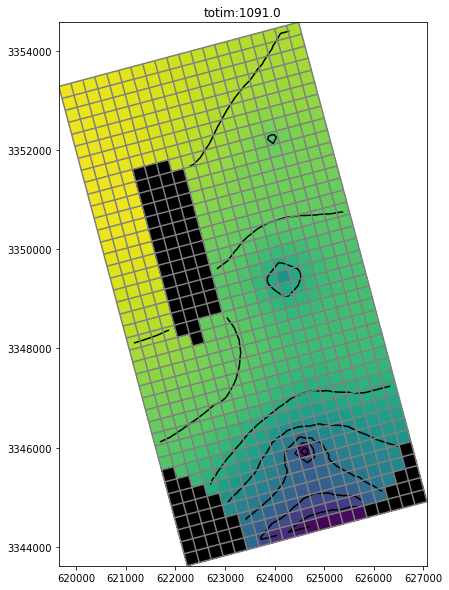

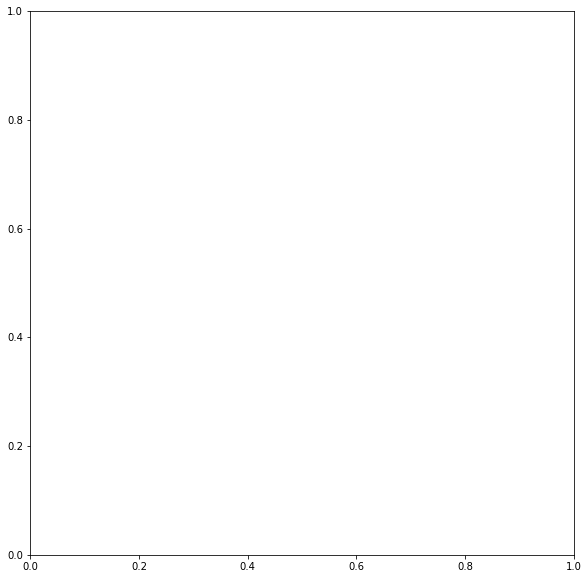

In [17]:
f = plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 1, 1, aspect="equal")
for i, t in enumerate(h.times[0:-1:10]):
    ax.set_title("totim:{0}".format(t))
    h.plot(totim=t, mflay=0, contour=True,
           grid=True, figsize=(10,10),
            vmin=0, vmax=20, axes=[ax])
    time.sleep(0.001)
    clear_output(True)
    display(f)
    ax.cla()